In [1]:
%matplotlib notebook

import os
import shutil
import numpy as np
import covseisnet as cn
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import h5py

from scipy.signal import tukey, butter, filtfilt
from scipy.stats import pearsonr

from time import time

from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

from bm3d import bm3d
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import numpy.ma as ma

In [2]:
def insert_str(string, str_to_insert, index):
    return string[:index] + str_to_insert + string[index:]
def suppr_str(string, index, number_to_suppr):
    temp= index+number_to_suppr
    return string[:index] + string[temp:]
def suppr_gaps(stream):
    for i in range(len(stream)):
        average = stream[i].data.mean()
        stream[i].data=ma.filled(stream[i].data,average)
    return stream
def merge_traces_data_together(stream,number):
    for i in range(0,640*number,number):
        stream[int(i/number)]=stream[i]
        for j in range(1,number):
            stream[int(i/number)]+=stream[i+j]
    for i in range(640):
        for j in range(number-1):
                stream.pop(640)
    return stream

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=2):
    
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    
    if low < 0:
        Wn = high
        btype = "lowpass"
    elif high < 0:
        Wn = low
        btype = "highpass"
    else:
        Wn = [low, high]
        btype = "bandpass"

    b, a = butter(order, Wn, btype=btype)
    
    return b, a


def taper_filter(arr, fmin, fmax, samp_DAS):
    b_DAS, a_DAS = butter_bandpass(fmin, fmax, samp_DAS)
    window_time = tukey(arr.shape[1], 0.1)
    print(window_time)
    arr_wind = arr * window_time
    arr_wind_filt = filtfilt(b_DAS, a_DAS, arr_wind, axis=-1)
    return arr_wind_filt


def xcorr(x, y,i=0,j=0):
    
    # FFT of x and conjugation
    X_bar = np.fft.rfft(x).conj()
    Y = np.fft.rfft(y)
    
    # Compute norm of data
    norm_x_sq = np.sum(x**2)
    norm_y_sq = np.sum(y**2)
    norm = np.sqrt(norm_x_sq * norm_y_sq)
    if norm ==0:
        print("i",i)
    # Check if norm is zero before dividing
    
    # Correlation coefficients
    R = np.fft.irfft(X_bar * Y) / norm
    
    # Return correlation coefficient
    return np.max(R)

def compute_xcorr_window(x):
    Nch = x.shape[0]
    Cxy = np.zeros((Nch, Nch)) * np.nan
    
    for i in range(Nch):
        for j in range(i):
            Cxy[i, j] = xcorr(x[i], x[j],i,j)
    return np.nanmean(Cxy)

def compute_moving_coherence(data, bin_size):
    
    N_ch = data.shape[0]
    
    cc = np.zeros(N_ch)
    
    for i in range(N_ch):
        start = max(0, i - bin_size // 2)
        stop = min(i + bin_size // 2, N_ch)
        ch_slice = slice(start, stop)
        # slice of size bin_size ( smaller at the end and at the start of the dataset)
        cc[i] = compute_xcorr_window(data[ch_slice])
    return cc

In [4]:
with open('my_big_list.txt', 'r') as f:
    contents = f.read()

list_of_strings = contents.split('\n')
listing = [str(item) for item in list_of_strings if item]

In [5]:
cwd = os.getcwd()
N_ch =640
N_t=2048*4
data_dir = os.path.join(cwd, "reconstruction_snr_1_clean_inputs_big_model")
data_recs = np.zeros((len(listing[0:39]),N_ch,N_t))
for i in range(len(listing[0:39])):
    data_rec_file = os.path.join(data_dir, f"reconstruction_{i}.h5")
    with h5py.File(data_rec_file, "r") as h5f:
        data_recs[i] = h5f["strain_rate"][...]

In [6]:
input_number = 20
data = np.load(listing[input_number])

In [9]:
bin_size=10
cc_data = compute_moving_coherence(data, bin_size)
cc_rec = compute_moving_coherence(data_recs[input_number], bin_size)
cc_gain = cc_rec / cc_data

In [10]:
max_index=np.argmax(cc_gain[200:300])
print(cc_gain[max_index+200])
print(max_index+200)

1.9852780457083978
287


<IPython.core.display.Javascript object>


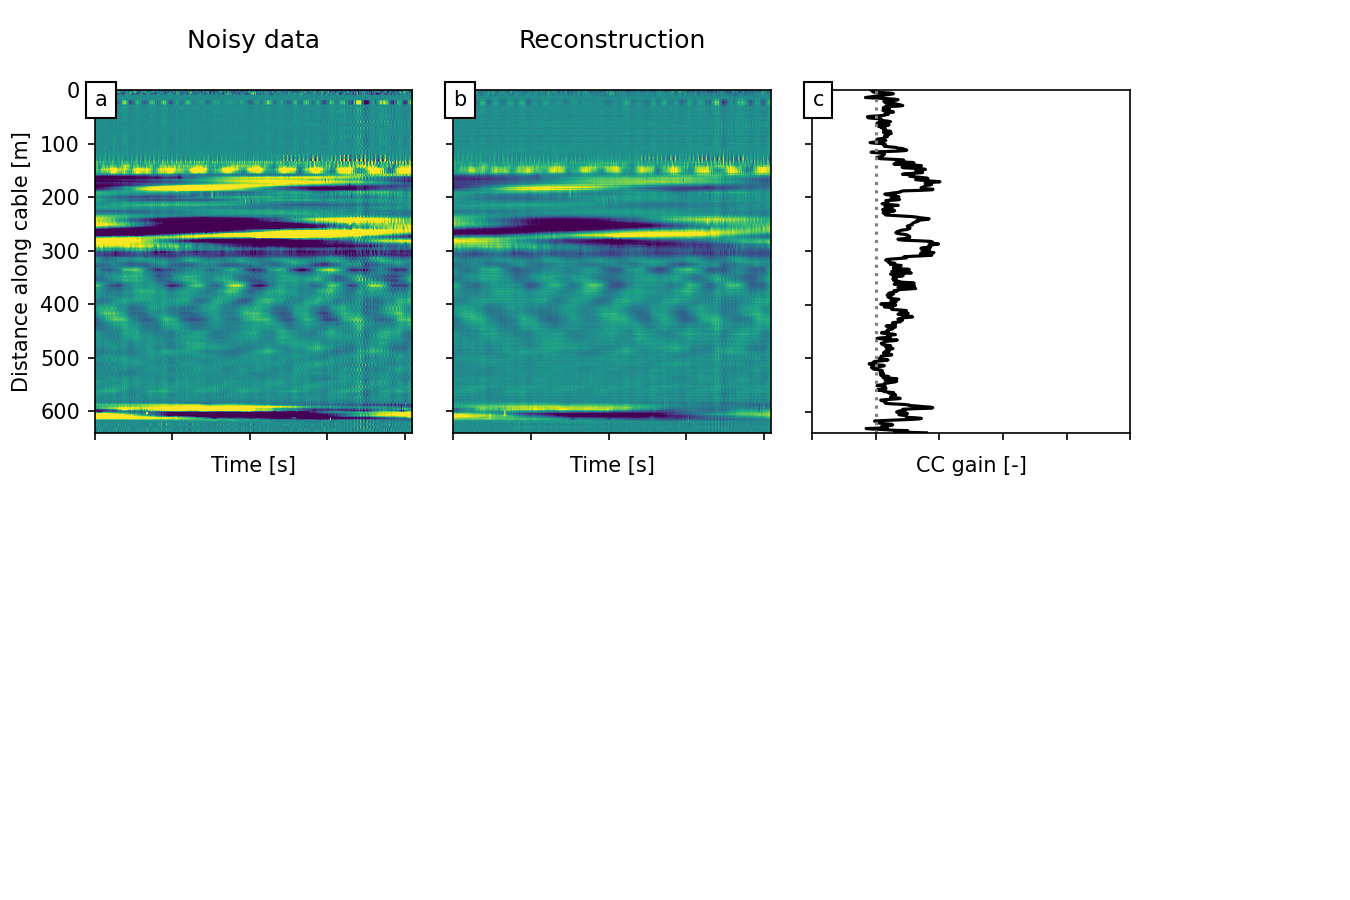

In [11]:
gauge = 1
samp=4000
dist = np.arange(N_ch) * gauge

imshow_params = {
    "vmin": -0.5,
    "vmax": 0.5,
    "aspect": "auto",
    "interpolation": "antialiased",
    "cmap": "viridis",
    "extent": [0, N_t/samp, N_ch*gauge, 0],
    "rasterized": True,
}

letters = "abcdefghijk"
letter_params = {
    "fontsize": 10,
    "verticalalignment": "top",
    "bbox": {"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
}


# Draw canvas
fig = plt.figure(figsize=(9, 6), dpi=150)
gs = fig.add_gridspec(2, 7)

axes = []

""" Panel a """
ax = fig.add_subplot(gs[0, 0:2])
axes.append(ax)
ax.imshow(data, **imshow_params)
ax.set_ylabel("Distance along cable [m]")
ax.set_title("Noisy data", pad=20)
ax.xaxis.set_ticklabels([])
ax.set_ylabel("Distance along cable [m]")
ax.set_xlabel("Time [s]")

""" Panel b """
ax = fig.add_subplot(gs[0, 2:4])
axes.append(ax)
ax.imshow(data_recs[input_number], **imshow_params)
ax.set_title("Reconstruction", pad=20)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.set_xlabel("Time [s]")

""" Panel d """
ax = fig.add_subplot(gs[0, 4:6])
axes.append(ax)
ax.plot(cc_gain, dist, c="k")
ax.axvline(1, ls=":", c="gray")
ax.set_xlim((0, 5))
ax.set_ylim((dist.max(), dist.min()))
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
ax.set_xlabel("CC gain [-]")
# Add panel letters
for i, ax in enumerate(axes):
    if i < 4: 
        ax.text(x=0.0, y=1.0, transform=ax.transAxes, s=letters[i], **letter_params)
# Adjust panel positions
plt.subplots_adjust(top=0.9, bottom=0.1, left=0.07, right=0.97, hspace=0.1, wspace=0.3)

plt.savefig("figures/noisy_input_normal_model.pdf")
plt.show()

<IPython.core.display.Javascript object>


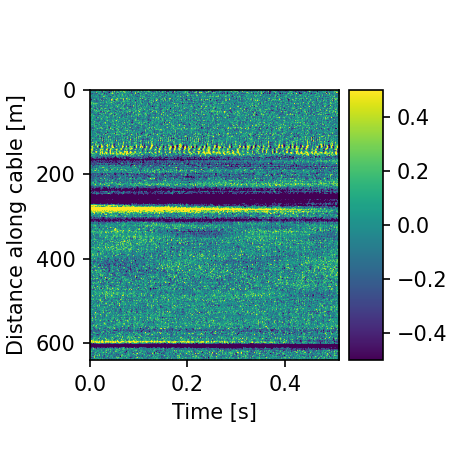

In [27]:
gauge = 1
samp=4000
Nch=640
Nt=2048
dist = np.arange(Nch) * gauge

imshow_params = {
    "vmin": -0.5,
    "vmax": 0.5,
    "aspect": "auto",
    "interpolation": "antialiased",
    "cmap": "viridis",
    "extent": [0, Nt/samp, Nch*gauge, 0],
    "rasterized": True,
}

letters = "abcdefghijk"
letter_params = {
    "fontsize": 10,
    "verticalalignment": "top",
    "bbox": {"edgecolor": "k", "linewidth": 1, "facecolor": "w",}
}


# Draw canvas
fig = plt.figure(figsize=(3, 3), dpi=150)
gs = fig.add_gridspec(1, 7)

axes = []

""" Panel a """
ax = fig.add_subplot(gs[0, 0:6])
axes.append(ax)
im = ax.imshow(data, **imshow_params)
ax.set_ylabel("Distance along cable [m]")
ax.set_xlabel("Time [s]")

# Color bar
cax = fig.add_subplot(gs[0, 6])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Amplitude [-]", labelpad=10)
# Adjust panel positions
plt.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.85, hspace=0.1, wspace=0.3)

plt.savefig("figures/original_image.pdf")
plt.show()

<IPython.core.display.Javascript object>


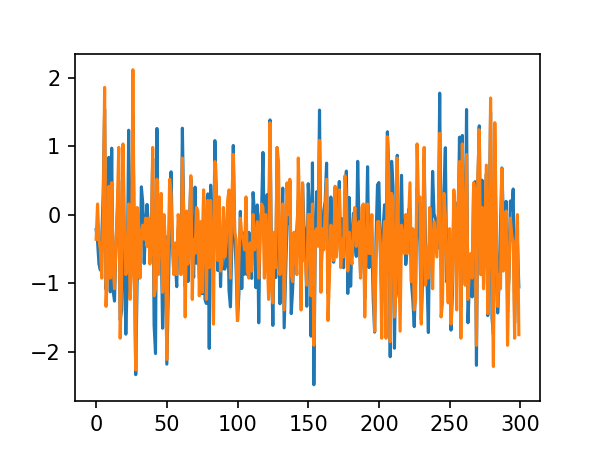

In [12]:
fig = plt.figure(figsize=(4, 3), dpi=150)
plt.plot(data[243][0:300])
#plt.plot(data_recs[input_number][243][0:300])
plt.plot(clean_data[243][0:300])

<IPython.core.display.Javascript object>


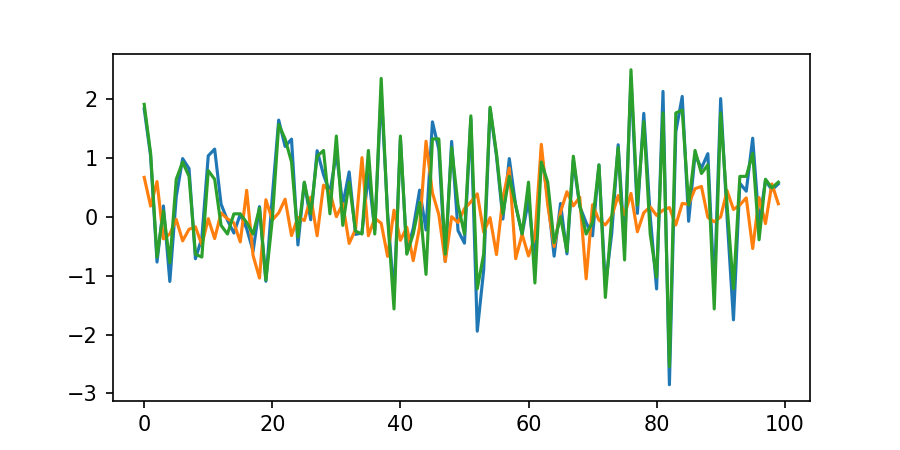

In [13]:
fig = plt.figure(figsize=(6, 3), dpi=150)
plt.plot(data[150][0:100])
plt.plot(data_recs[input_number][100][0:100])
plt.plot(clean_data[150][0:100])